### Import libraries

In [1]:
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

2.3.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Suppress warnings

In [3]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

### Load the dataset

In [5]:
(X_train_original, y_train), (X_test_original, y_test) = mnist.load_data()

X = tf.image.grayscale_to_rgb(tf.convert_to_tensor(np.reshape(X_train_original, X_train_original.shape + (1, )))).numpy()
X_test = tf.image.grayscale_to_rgb(tf.convert_to_tensor(np.reshape(X_test_original, X_test_original.shape + (1, )))).numpy()
y = tfk.utils.to_categorical(y_train, 10)
y_test = tfk.utils.to_categorical(y_test, 10)

#printing the shapes of the vectors 
print('X_train: ' + str(X.shape))
print('Y_train: ' + str(y.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28, 3)
Y_train: (60000, 10)
X_test:  (10000, 28, 28, 3)
Y_test:  (10000, 10)


### Split the dataset (circa 70-15-15)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1666666)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(50000, 28, 28, 3) (50000, 10)
(10000, 28, 28, 3) (10000, 10)
(10000, 28, 28, 3) (10000, 10)


### Show some data

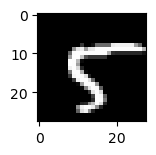

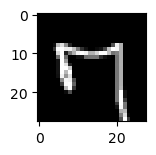

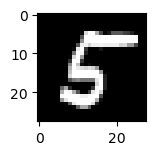

In [6]:
for i in range(3):  
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.show()

### Models metadata

In [8]:
input_shape = X_train.shape[1:]
image_shape = input_shape[:-1]
batch_size = 256
epochs = 200
labels = {0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}

# First attempt: use a Neural Network as classifier

Model: "standard_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 28, 28, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
classifier (Dense)           (None, 32)                75296     
_________________________________________________________________
classifier_dropout (Dropout) (None, 32)                0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                330       
Total params: 75,626
Trainable params: 75,626
Non-trainable params: 0
_________________________________________________________________


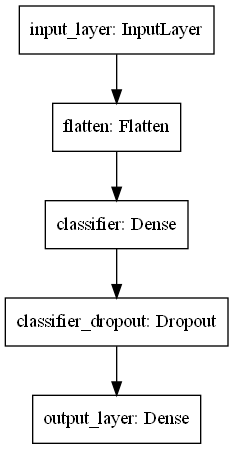

In [8]:
def build_model(input_shape):
    tf.random.set_seed(seed)
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = tfkl.Flatten()(input_layer)
    
    x = tfkl.Dense(
        units = 32,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_dropout')(x)

    output_layer = tfkl.Dense(
        units = 10, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'standard_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

standard_model = build_model(input_shape)
standard_model.summary()
tfk.utils.plot_model(standard_model)

### Train the model

In [9]:
standard_history = standard_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

Epoch 1/200
196/196 [==============================] - 1s 5ms/step - loss: 4.3105 - accuracy: 0.2083 - val_loss: 1.9014 - val_accuracy: 0.2895
Epoch 2/200
196/196 [==============================] - 1s 4ms/step - loss: 1.9666 - accuracy: 0.2689 - val_loss: 1.7474 - val_accuracy: 0.3595
Epoch 3/200
196/196 [==============================] - 1s 4ms/step - loss: 1.8946 - accuracy: 0.2987 - val_loss: 1.6031 - val_accuracy: 0.4453
Epoch 4/200
196/196 [==============================] - 1s 4ms/step - loss: 1.8015 - accuracy: 0.3360 - val_loss: 1.5030 - val_accuracy: 0.4602
Epoch 5/200
196/196 [==============================] - 1s 4ms/step - loss: 1.7060 - accuracy: 0.3706 - val_loss: 1.3843 - val_accuracy: 0.5107
Epoch 6/200
196/196 [==============================] - 1s 4ms/step - loss: 1.6838 - accuracy: 0.3736 - val_loss: 1.3928 - val_accuracy: 0.4782
Epoch 7/200
196/196 [==============================] - 1s 4ms/step - loss: 1.6565 - accuracy: 0.3817 - val_loss: 1.3398 - val_accuracy: 0.5036

KeyboardInterrupt: 

# Second attempt: use a CNN built by scratch

In [ ]:
def build_conv_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Conv2D(
        filters = 64,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(input_layer)
    
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_dropout')(x)

    output_layer = tfkl.Dense(
        units = 10, 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'convolutional_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

conv_model = build_conv_model(input_shape)
conv_model.summary()
tfk.utils.plot_model(conv_model)

### Train the model

In [ ]:
# Train the model
conv_history = conv_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

### Plot training results

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(standard_history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.plot(conv_history['loss'], label='Conv training', alpha=.3, color='#12a4e3', linestyle='--')
plt.plot(conv_history['val_loss'], label='Conv validation', alpha=.8, color='#12a4e3')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(standard_history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(standard_history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.plot(conv_history['accuracy'], label='Conv training', alpha=.3, color='#12a4e3', linestyle='--')
plt.plot(conv_history['val_accuracy'], label='Conv validation', alpha=.8, color='#12a4e3')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Predict the test set
standard_predictions = standard_model.predict(X_test)
conv_predictions = conv_model.predict(X_test)

# Plot the target images and the predictions
prediction_index = 20

fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(18,5)
ax1.imshow(X_test[prediction_index])
ax1.set_title('True label: '+labels[np.argmax(y_test[prediction_index])])
ax2.barh(list(labels.values()), standard_predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax2.set_title('SNN Predicted label: '+labels[np.argmax(standard_predictions[prediction_index])])
ax2.grid(alpha=.3)
ax3.barh(list(labels.values()), conv_predictions[prediction_index], color=plt.get_cmap('Paired').colors)
ax3.set_title('CNN Predicted label: '+labels[np.argmax(conv_predictions[prediction_index])])
ax3.grid(alpha=.3)
plt.show()

In [ ]:
# Compute the confusion matrix
predictions = standard_predictions  # Change this to "standard" or "conv" to see different results
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the obtained model (only if it represents a real improvement)

In [ ]:
restored_model = tfk.models.load_model('StandardModel')
restored_loss, restored_acc = restored_model.evaluate(X_test, y_test, verbose=2)  
loss, acc = conv_model.evaluate(X_test, y_test, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    conv_model.save('StandardModel')
else:
    conv_model = restored_model
    print("Model restored!")

### Lets try on your image

In [ ]:
# uncomment this line if you want to use the saved model as the conv_model
#conv_model = tfk.models.load_model('StandardModel')

with Image.open("test_image.png") as img:
    rgb_image = img.convert('RGB')
    X = np.expand_dims(rgb_image, axis=0)
    X = 255 - X
    standard_prediction = standard_model.predict(X) 
    conv_prediction = conv_model.predict(X)
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.set_size_inches(18,5)
    ax1.imshow(np.reshape(X, input_shape))
    ax1.set_title('Your image (inverted):')
    ax2.barh(list(labels.values()), np.reshape(standard_prediction, (10, )), color=plt.get_cmap('Paired').colors)
    ax2.set_title('SNN Predicted label: '+ labels[np.argmax(standard_prediction)])
    ax2.grid(alpha=.3)
    ax3.barh(list(labels.values()), np.reshape(conv_prediction, (10, )), color=plt.get_cmap('Paired').colors)
    ax3.set_title('CNN Predicted label: '+ labels[np.argmax(conv_prediction)])
    ax3.grid(alpha=.3)
    plt.show()

# Third attempt: enhance the SNN using Data Augmentation

##### ImageDataGenerator allows to perform data augmentation

```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)
```

### Lets define the transformations we're interesetd in

Transform: {'theta': -5.0183952461055, 'tx': 0, 'ty': 2, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None}


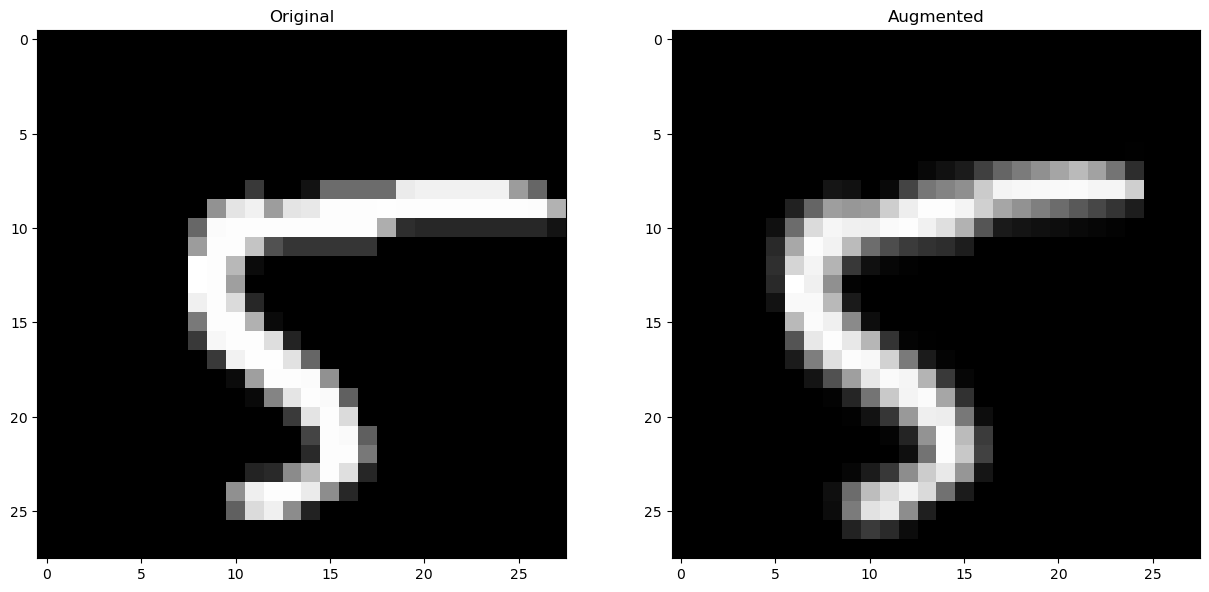

In [9]:
# Combine multiple transformations
shift_range = 4
gen = ImageDataGenerator(rotation_range=20,
                         height_shift_range=shift_range,
                         width_shift_range=shift_range,
                         fill_mode='constant')

# Get random transformation
image = X_train[0]
t = gen.get_random_transform(img_shape=image_shape, seed=seed)
print("Transform:", t)

# Apply the transformation
augmented = gen.apply_transform(image, t)

# Plot original and augmented image
fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(np.uint8(image))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(augmented))
ax[1].set_title("Augmented")
plt.show()

### Lets create the real generator and analyze a single sample batch

In [ ]:
# Obtain a data generator with the 'ImageDataGenerator.flow()' method
train_gen = gen.flow(X_train, 
                     y_train,
                     batch_size=2,
                     seed=seed)

# Get sample batch
batch = next(train_gen)
print(batch[0].shape)
print(batch[1].shape)

image1 = batch[0][0]
print(batch[1][0])
image2 = batch[0][1]
print(batch[1][1])

fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(np.uint8(image1))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(image2))
ax[1].set_title("Augmented")
plt.show()

### Training with data augmentation

In [ ]:
# Re-train the model (same effect of doubling the dataset size: calling .fit() multiple times trains the model incrementally)
history = standard_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)],
).history

### Lets compare to previous results

In [ ]:
# Predict the test set
standard_predictions = standard_model.predict(X_test)

# Compute the confusion matrix
predictions = standard_predictions
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Fourth attempt: find a way to produce a specified amount of augmented images, include them in the training set and then repeat the training from zero

### Inspect the targets distribution

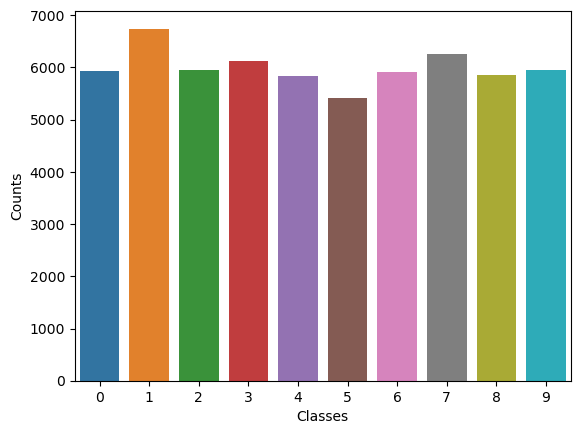

In [7]:
classes, counts = np.unique(np.fromiter([np.argmax(x) for x in y], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

### Lets suppose we want a specified amount of sample for each class

In [10]:
desired_amount = 7000

ref_list = []
aug_samples = []
aug_targets = []

for i in range(0, len(classes)):
    ref_list.append([])
    
for i in range(0, len(y)):
    ref_list[np.argmax(y[i])].append(X[i])

for i in range(0, len(classes)):
    length = len(ref_list[i])
    to_produce = desired_amount - length
    target = tfk.utils.to_categorical(i, len(classes))
    print(f'Computing {to_produce} augmented images for target {i} -> {target}')
    aug_targets_i = np.full((length, len(classes)), target)
    aug_gen_i = gen.flow(np.array(ref_list[i]), 
                         aug_targets_i,
                         batch_size=1,
                         seed=seed,
                         shuffle=True)
    for j in range(0, to_produce):
        aug_samples.append(np.squeeze(next(aug_gen_i)[0]))
        aug_targets.append(target)

X_aug = np.concatenate((X, np.array(aug_samples)))
y_aug = np.concatenate((y, np.array(aug_targets)))

Computing 1077 augmented images for target 0 -> [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Computing 258 augmented images for target 1 -> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Computing 1042 augmented images for target 2 -> [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Computing 869 augmented images for target 3 -> [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Computing 1158 augmented images for target 4 -> [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Computing 1579 augmented images for target 5 -> [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Computing 1082 augmented images for target 6 -> [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Computing 735 augmented images for target 7 -> [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Computing 1149 augmented images for target 8 -> [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Computing 1051 augmented images for target 9 -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### Lets inspect now our dataset distribution

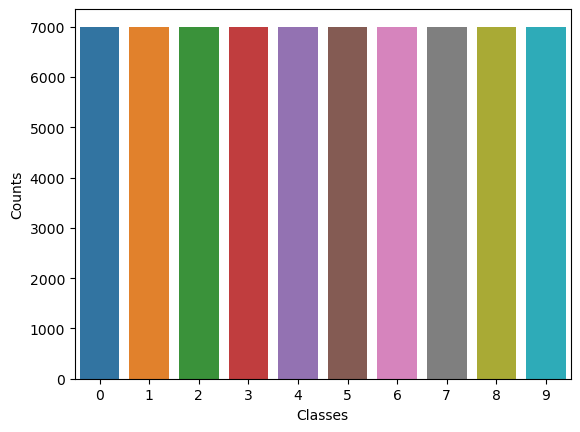

In [11]:
classes, counts = np.unique(np.fromiter([np.argmax(x) for x in y_aug], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

### We need to re-perform the train-validation split and then repeat the training

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, stratify=y_aug, test_size=0.15)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(59500, 28, 28, 3) (59500, 10)
(10500, 28, 28, 3) (10500, 10)
(10000, 28, 28, 3) (10000, 10)


In [ ]:
aug_model = build_conv_model(input_shape)

aug_history = aug_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True)]
).history

### Comparing the trainings and results

In [ ]:
# Predict the test set
aug_predictions = aug_model.predict(X_test)

# Compute the confusion matrix
predictions = aug_predictions
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=list(labels.values()), yticklabels=list(labels.values()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()